### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [1]:
import numpy as np
import pandas as pd 
import random

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_w=data.resample('W').mean()
#data_w.iloc[:,1:] = data_w.iloc[:,1:] // 168
target='PJME_MW'

In [4]:
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [5]:
data_w.drop(['hour', 'dayofmonth', 'dayofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1,inplace=True)
data_w.head()

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0


In [6]:
data_w.tail()

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2018-07-08,38459.982143,2018.0,7.000000,3.0,27.0
2018-07-15,36420.035714,2018.0,7.000000,3.0,28.0
2018-07-22,35612.095238,2018.0,7.000000,3.0,29.0
2018-07-29,36581.821429,2018.0,7.000000,3.0,30.0
2018-08-05,36568.804124,2018.0,7.505155,3.0,31.0


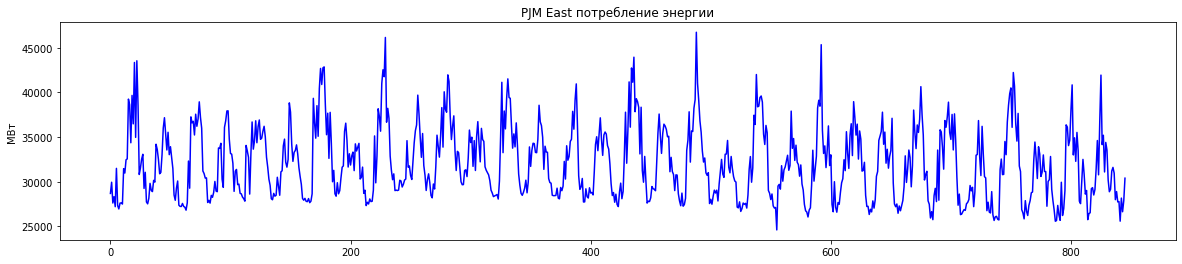

In [9]:
plt.figure(figsize =(20,4))
plt.plot(data_w['PJME_MW'].values[10:-10], 'b' )  #.get_level_values('Date')
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()


### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.



In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]]           # first value is same as series
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i - 1])
    return np.array(result)

In [11]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

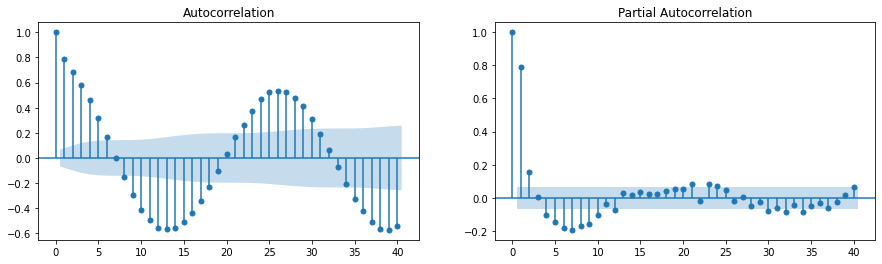

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
lag = 40

sm.graphics.tsa.plot_acf(data_w[target].values, lags=lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(data_w[target].values, lags=lag, ax=axes[1])
plt.show()

Text(0.5, 1.0, 'PJME_MW')

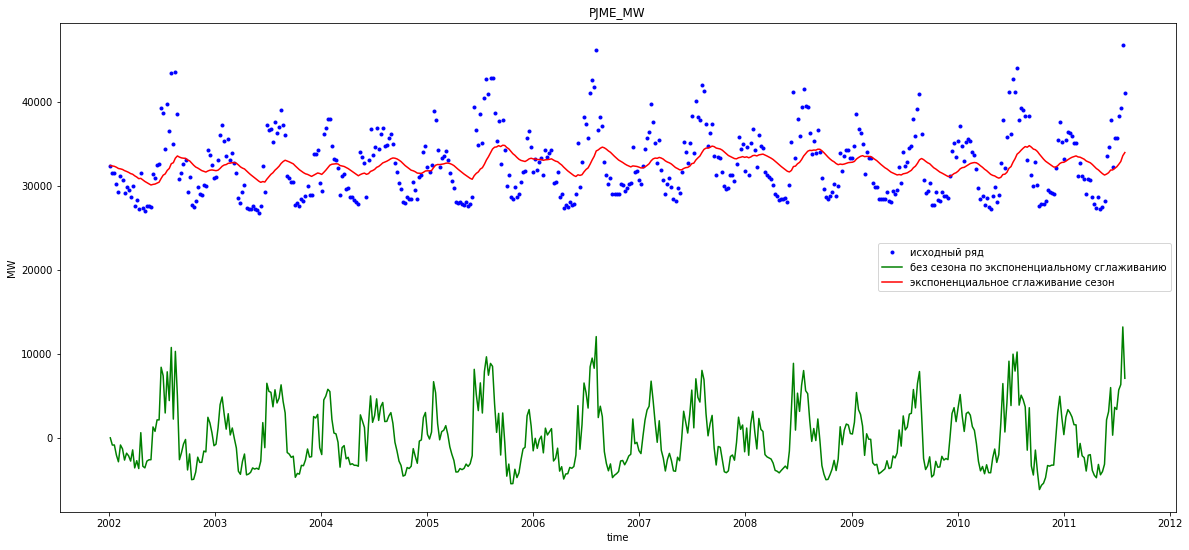

In [13]:
data_exp_1 = exponential_smoothing(data_w['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(data_w.index[:500], data_w['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(data_w.index[:500],data_w['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(data_w.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [14]:
df= pd.DataFrame(data_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0.0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0.0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values

df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
0,32392.160839,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839,0.000000
1,32346.922142,32392.160839,0.000000,0.000000,32391.708452,32390.803678,32388.541743,45.238697
2,32302.220083,32346.922142,32392.160839,0.000000,32390.813569,32388.146170,32381.636011,44.702060
3,32194.185567,32302.220083,32346.922142,32392.160839,32388.847288,32382.327352,32366.639975,108.034516
4,32044.300693,32194.185567,32302.220083,32346.922142,32385.401823,32372.186553,32340.852833,149.884874


In [15]:
# добавим историю на глубину 4 измерения от текущего (р=4)
p = 4
for i in range(1, p+1):
    data_w[f't{i}'] = 0.0
    data_w.iloc[i:,i+4]=data_w.iloc[:-i,0].values
data_w.fillna(0)
# добавим сглаживание 
data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)
# добавим первую разность
data_w['diff1'] = 0.0
data_w['diff1'].iloc[1:] = data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values
data_w.head()

,PJME_MW,year,month,quarter,weekofyear,t1,t2,t3,t4,exp_0_05,diff1
Date,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,32392.160839,0.000000
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0,32392.160839,0.000000,0.000000,0.000000,32346.922142,-904.773934
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0,31487.386905,32392.160839,0.000000,0.000000,32302.220083,-34.505952
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0,31452.880952,31487.386905,32392.160839,0.000000,32194.185567,-1311.351190
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0,30141.529762,31452.880952,31487.386905,32392.160839,32044.300693,-945.041667


In [16]:
spl_data = '2018-01-01'


In [17]:
train, test = split_data( data_w, spl_data)


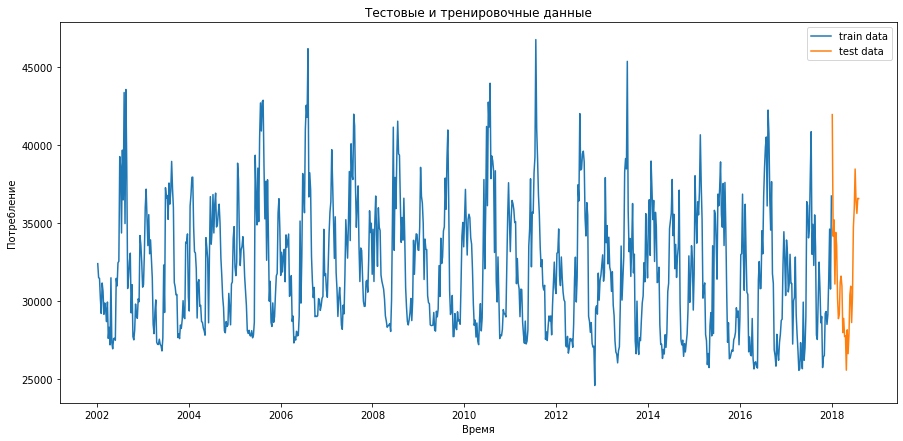

In [18]:
h=4
X_train = train.iloc[:-h,:]
y_train = train[data_w.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[data_w.columns[0]].values[h:]

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(train.index.get_level_values('Date'),train[data_w.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'),test[data_w.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

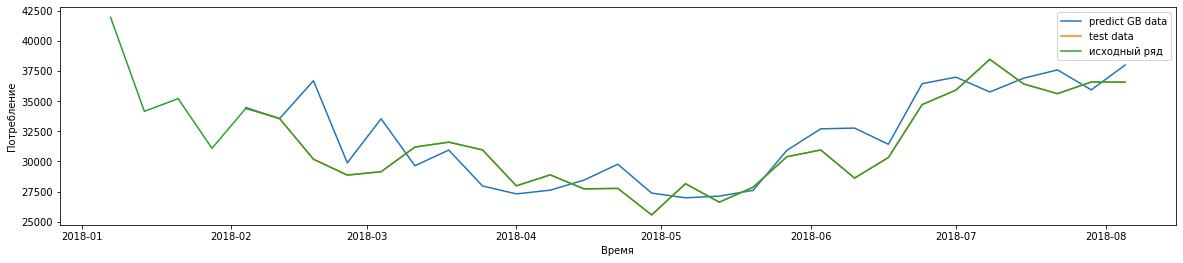

средняя ошибка в процентном отношении:   5.215869892761953 %


In [20]:

model_gb4 = GradientBoostingRegressor(max_depth=7, random_state=0, n_estimators=100)
model_gb4.fit( X_train, y_train ) 
y_pred4 = model_gb4.predict(X_test)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(test.index[h:],y_pred4, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(data_w.loc[spl_data:].index, data_w.loc[spl_data:]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred = y_pred4)

print('средняя ошибка в процентном отношении:  ', er_g, '%')

In [21]:
for i in range(5):
    er_g = mean_absolute_percentage_error(y_true=y_test[i*h:i*h+h], y_pred = y_pred4[i*h:i*h+h])
    print(f'средняя ошибка на интервале {i*h}:{i*h+h} \t {round(er_g,2)} %')

средняя ошибка на интервале 0:4 	 6.32 %
средняя ошибка на интервале 4:8 	 7.95 %
средняя ошибка на интервале 8:12 	 4.15 %
средняя ошибка на интервале 12:16 	 3.52 %
средняя ошибка на интервале 16:20 	 6.39 %


In [22]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_pred4) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred4) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred4)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   4660000.638750933 
ошибка mae  :   1598.5747561717667 
оценка R2 :   0.6293939108376603


In [23]:
y_pred4


array([34466.84295071, 33547.26919813, 36687.66354863, 29875.82158907,
       33530.22051489, 29638.85509832, 30936.1202641 , 27957.33391411,
       27304.64917266, 27611.01549784, 28445.44339753, 29760.80440698,
       27371.97890032, 26977.73911331, 27119.46375693, 27592.88461177,
       30916.05549413, 32698.0902555 , 32760.46493718, 31419.54980156,
       36444.41890271, 36982.3885775 , 35754.80120717, 36897.12326335,
       37584.41990121, 35927.84257541, 37987.93924676])

### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

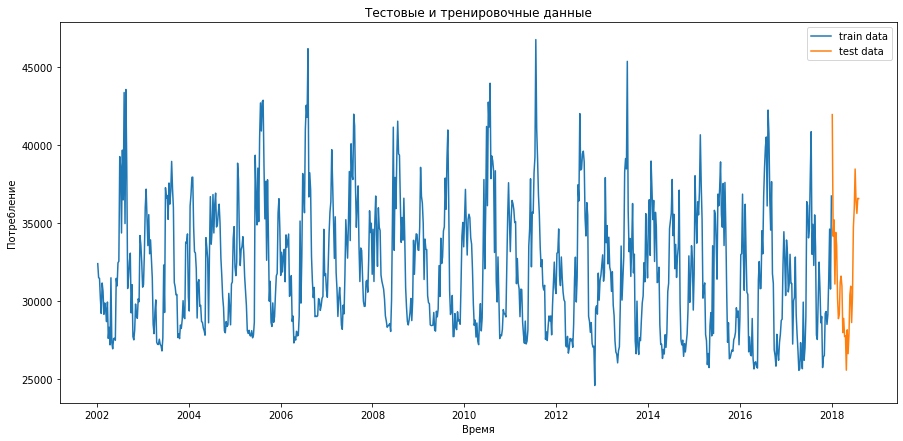

In [24]:
h=1
X_train = train.iloc[:-h,:]
y_train = train[data_w.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[data_w.columns[0]].values[h:]

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(train.index.get_level_values('Date'),train[data_w.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'),test[data_w.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

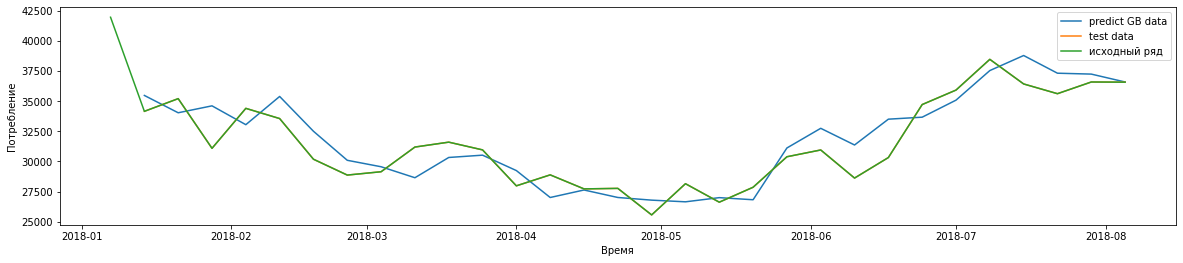

средняя ошибка в процентном отношении:   4.443667552688989 %


In [25]:

model_gb = GradientBoostingRegressor(max_depth=7, random_state=0, n_estimators=100)
model_gb.fit( X_train, y_train ) 
y_pred = model_gb.predict(X_test)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(test.index[h:],y_pred, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(data_w.loc[spl_data:].index, data_w.loc[spl_data:]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred = y_pred)

print('средняя ошибка в процентном отношении:  ', er_g, '%')

In [26]:
h4 = 4
for i in range(5):
    er_g = mean_absolute_percentage_error(y_true=y_test[i*h4:i*h4+h4], y_pred = y_pred[i*h4:i*h4+h4])
    print(f'средняя ошибка на интервале {i*h4}:{i*h4+h4} \t {round(er_g,2)} %')

средняя ошибка на интервале 0:4 	 5.61 %
средняя ошибка на интервале 4:8 	 4.7 %
средняя ошибка на интервале 8:12 	 4.53 %
средняя ошибка на интервале 12:16 	 3.59 %
средняя ошибка на интервале 16:20 	 3.22 %


In [27]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_pred) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   2655034.56778335 
ошибка mae  :   1384.1215226071208 
оценка R2 :   0.7796977466875513


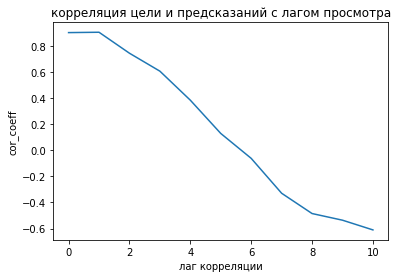

In [28]:

lag=10
p_cor=[np.corrcoef( y_test, y_pred)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_pred[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

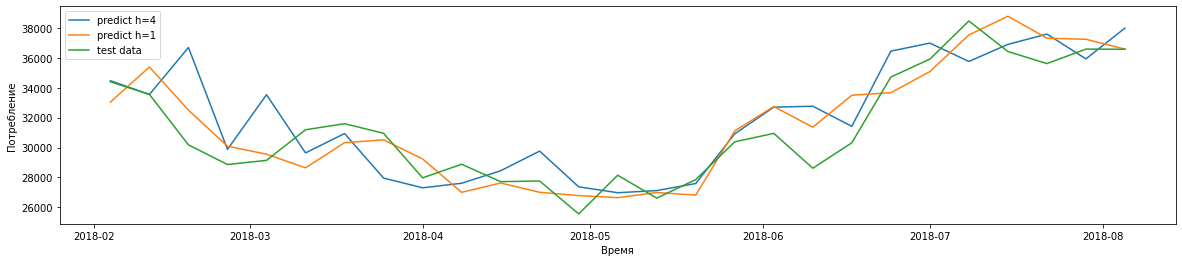

In [29]:

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(test.index[4:],y_pred4, label='predict h=4' )
plt.plot(test.index[4:],y_pred[3:], label='predict h=1' )
plt.plot(test.index[4:],y_test[3:], label='test data')

plt.legend()

### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [40]:
def recursion_model(X, y, p):

    X_r = X.copy()
    y_r = y.copy()
    N = 21#22 точки у y_test
    for i in range(N):
        y_r[i] = model_gb.predict(X_r.iloc[i:])[0]

        # заполняем вектор для прогноза следующей точки
        X_r.iloc[i+1,0] = y_r[i]
        X_r.iloc[i+1,5] = X_r.iloc[i,0]
        if i > 0:
            X_r.iloc[i+1,6] = X_r.iloc[i-1,0]
        if i > 1:
            X_r.iloc[i+1,7] = X_r.iloc[i-2,0]
        if i > 2:
            X_r.iloc[i+1,8] = X_r.iloc[i-3,0]
        X_r.iloc[i+1,10] = X_r.iloc[i+1,0] - X_r.iloc[i+1,5]


        #строим 'exp_0_05', 
        X_r.iloc[i+1,9] = X_r.iloc[i,9]*(1-0.05)+ 0.05 * X_r.iloc[i+1,0] 



    plt.figure( figsize=( 15, 7 ))


    plt.xlabel('Время')
    plt.ylabel('Потребление энергии, МВт')

    plt.plot(test.index[4:],y_pred4, label='predict h=4' )
    # plt.plot(test.index[4:],y_pred[3:], label='predict h=1' )
    plt.plot(test.index[4:],y_test[3:], label='test data')
    plt.plot(test.index[4:],y_r[3:], label='predict_rec')


    plt.legend()
    plt.show()
    
    return y_pred


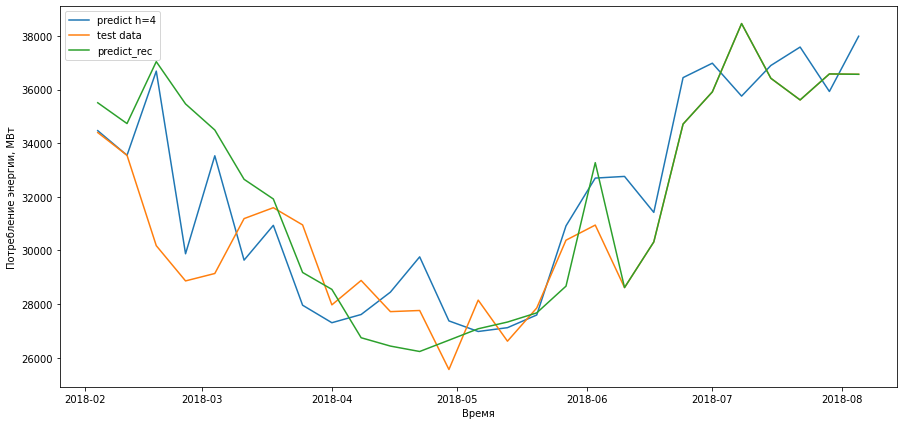

средняя ошибка в процентном отношении: = 3.024186992704407%


In [43]:
h = 4

y_pred_c = recursion_model(X=X_test, y=y_test, p=h)

err_rec = mean_absolute_percentage_error(y_pred4[-h:], y_r[-h:])

print(f'средняя ошибка в процентном отношении: = {err_rec}%')

### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... , от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

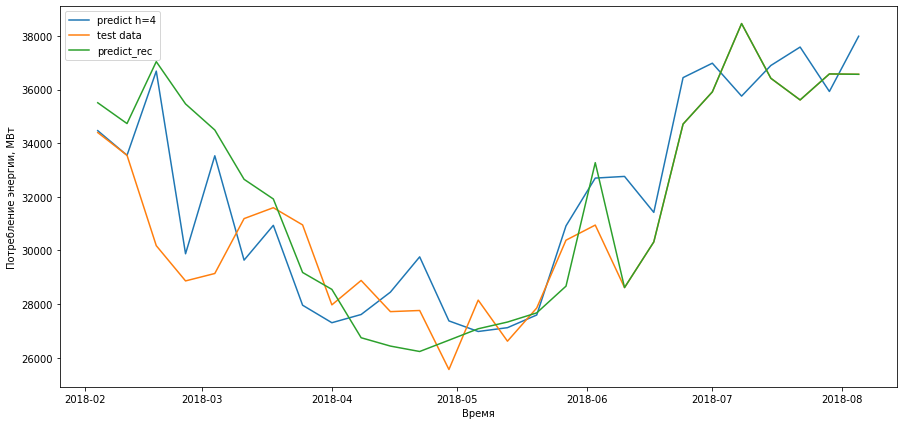

средняя ошибка в процентном отношении: = 4 - 3.024186992704407%


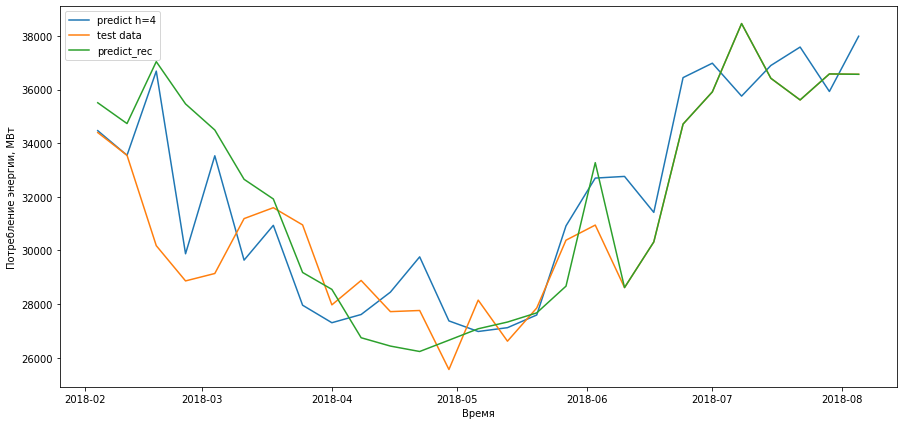

средняя ошибка в процентном отношении: = 6 - 3.7595709789116585%


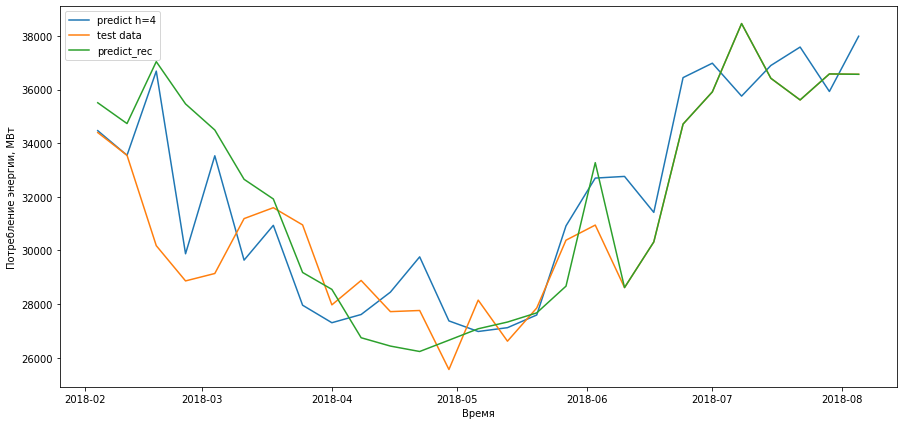

средняя ошибка в процентном отношении: = 8 - 3.8526613803860648%


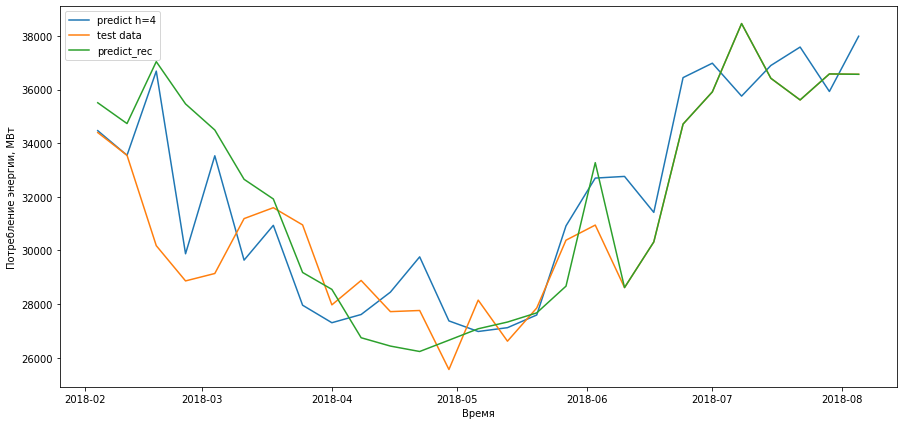

средняя ошибка в процентном отношении: = 10 - 4.523370577420635%


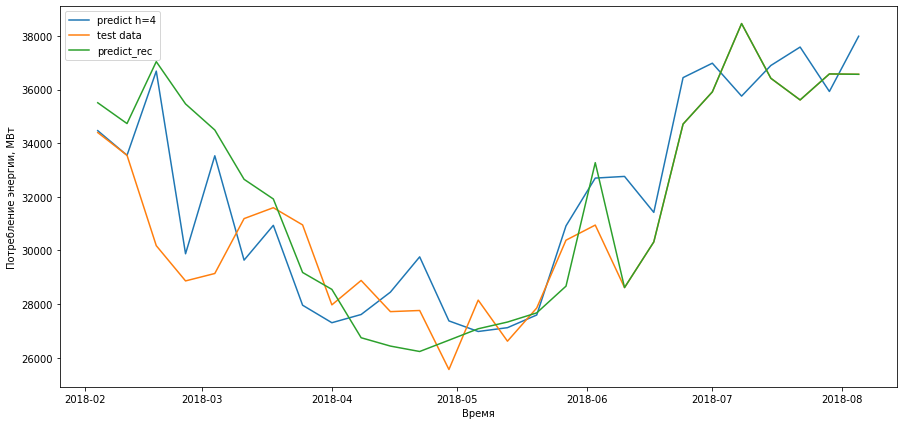

средняя ошибка в процентном отношении: = 12 - 4.399254740655043%


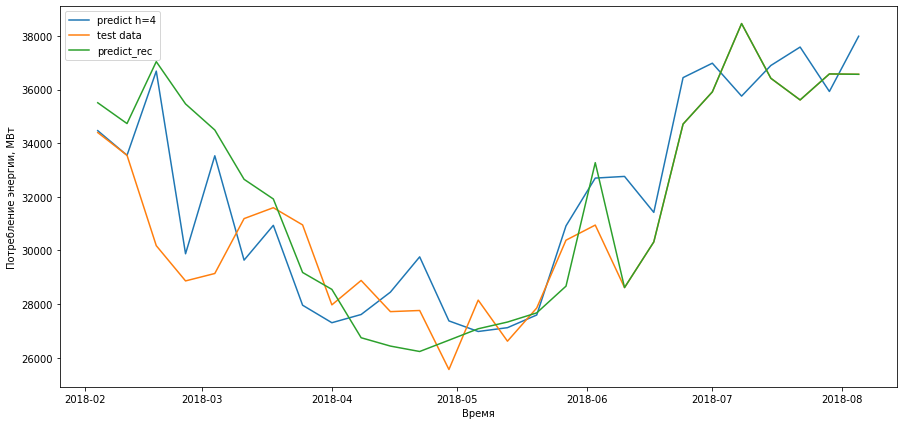

средняя ошибка в процентном отношении: = 14 - 3.8530243176029253%


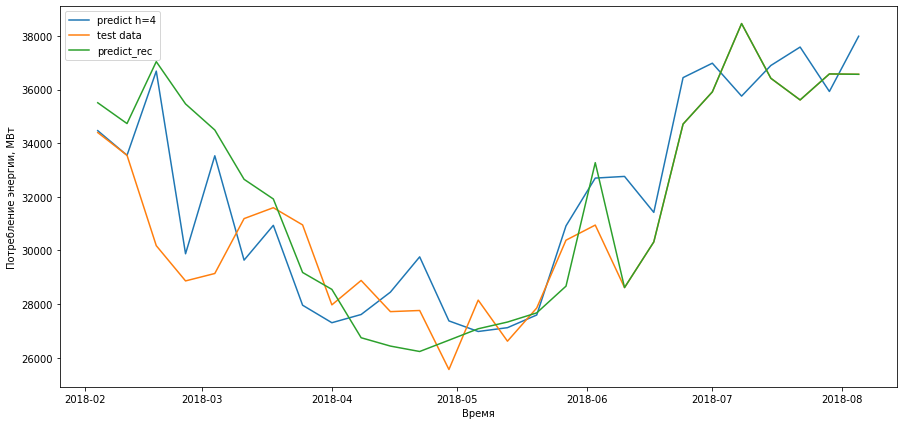

средняя ошибка в процентном отношении: = 16 - 4.276694964430231%


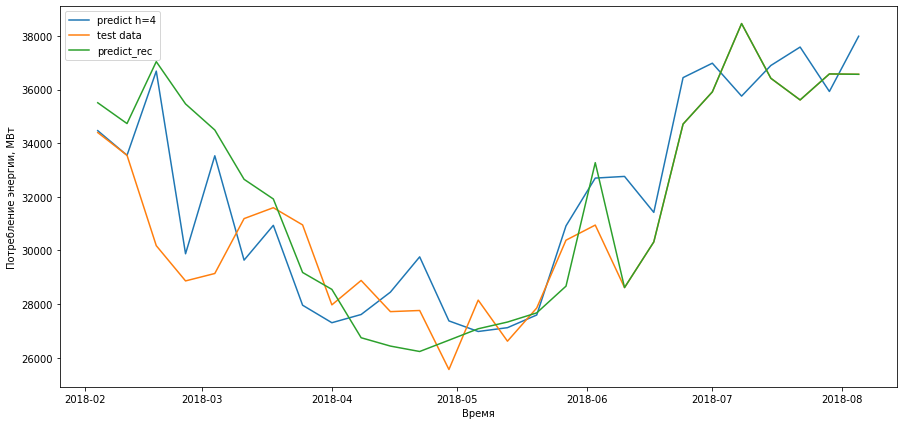

средняя ошибка в процентном отношении: = 18 - 4.368768636687328%


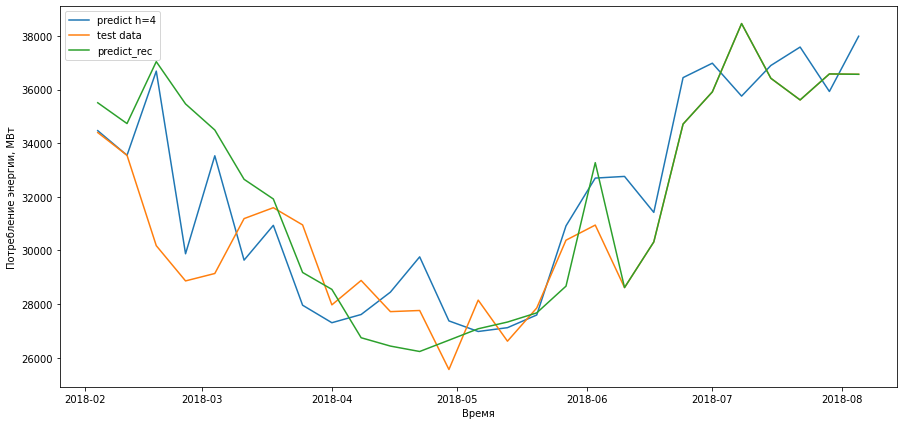

средняя ошибка в процентном отношении: = 20 - 4.377850587806238%


In [46]:
coef = list(range(2, 11))
err_list = []

for i in coef:
    
    p = 2*i
    
    y_pred_c = recursion_model(X=X_test, y=y_test, p=p)

    err_rec = mean_absolute_percentage_error(y_pred4[-p:], y_r[-p:])
    
    err_list.append(err_rec)

    print(f'средняя ошибка в процентном отношении: = {p} - {err_rec}%')

### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Ошибка не имеет четкой тенденции, что растет до одного значения, а потом падает (или наоборот), а меняется в разном направлении в зависимости от параметра. поэтому для оптимального решения нужно подбирать лучшее значение. 